In [1]:
adsorbate = 'CO'
model_name = 'model0'

# Fitting a model

## Get the training data

In [2]:
import numpy as np
from gaspy import gasdb

docs = gasdb.get_adsorption_docs(adsorbates=[adsorbate])
energies_dft = np.array([doc['energy'] for doc in docs])

0it [00:00, ?it/s]

Now pulling adsorption documents...


20985it [00:01, 20350.99it/s]


## Processing the features
Make a pipeline to preprocess the features

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from gaspy_regress import fingerprinters

inner_fingerprinter = fingerprinters.InnerShellFingerprinter()
outer_fingerprinter = fingerprinters.OuterShellFingerprinter()
fingerprinter = fingerprinters.StackedFingerprinter(inner_fingerprinter, outer_fingerprinter)

scaler = StandardScaler()
pca = PCA()

preprocessing_pipeline = Pipeline([('fingerprinter', fingerprinter),
                                   ('scaler', scaler),
                                   ('pca', pca)])
features = preprocessing_pipeline.fit_transform(docs)

0it [00:00, ?it/s]

Now pulling catalog documents...


2591434it [01:35, 27221.96it/s]
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jovyan/GASpy/GASpy_regressions/gaspy_regress/fingerprinters.py:236: RuntimeWarning: We do not have any energy data for C, so we set its median adsorption energy as the median of all energies
  warnings.warn(message, RuntimeWarning)
/home/jovyan/GASpy/GASpy_regressions/gaspy_regress/fingerprinters.py:236: RuntimeWarning: We do not have any energy data for H, so we set its median adsorption energy as the median of all energies
  warnings.warn(message, RuntimeWarning)
/home/jovyan/GASpy/GASpy_regressions/gaspy_regress/fingerprinters.py:236: RuntimeWarning: We do not have any energy data for Mn, so we set its median adsorption energy as the median of all energies
  

Now pulling catalog documents...


2591434it [02:16, 19012.01it/s]


## Performing the regression
First fit TPOT

In [4]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(
                     generations=1,
                     population_size=16,
                     offspring_size=16,
                     verbosity=2,
                     #random_state=42,
                     scoring='neg_median_absolute_error',
                     n_jobs=16,
                    )
energies_ml = tpot.fit_predict(features, energies_dft)

Generation 1 - Current best internal CV score: -0.15149467893474894

Best pipeline: ElasticNetCV(RandomForestRegressor(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.2, min_samples_leaf=15, min_samples_split=19, n_estimators=100), bootstrap=False, max_features=0.65, min_samples_leaf=4, min_samples_split=13, n_estimators=100), l1_ratio=0.65, tol=0.01)


Now create and save the final pipeline. We fit in two stages because we can't pickle TPOT objects, but we can pickle the pipeline that TPOT creates. Therefore, we fit TPOT separately so that we can pull its pipeline out.

In [5]:
# Make the pipeline
steps = [('fingerprinter', fingerprinter),
         ('scaler', scaler),
         ('pca', pca)]
for step in tpot.fitted_pipeline_.steps:
    steps.append(step)
pipeline = Pipeline(steps)

In [6]:
import pickle
from gaspy.utils import read_rc

# Save the pipeline
gasdb_location = read_rc('gasdb_path')
file_name = gasdb_location + '/pipeline_%s_%s.pkl' % (adsorbate, model_name)
with open(file_name, 'wb') as file_handle:
    pickle.dump(pipeline, file_handle)

Let's make sure our pipeline does what we think it should be doing.

In [7]:
import numpy.testing as npt

energies_from_pipeline = pipeline.predict(docs)
npt.assert_allclose(energies_ml, energies_from_pipeline, rtol=1e-7, atol=1e-5)

# Visualizing the regression
Note that we visualize the fit on only our training set, so the fit will look much better than it actually is. People normally combat this by doing train/test splits, but our workflow is online and iterative, thereby invalidating the normal train/test splitting workflow.

A proper method to verify quality of our fit is to do an [evaluation on a rolling forecasting origin](https://robjhyndman.com/hyndsight/tscv/), but that takes a lot of computational resources to perform retroactively. So we dedicate that for an entirely different notebook

What these plots tell us, at least, is that we did not perform the fitting horribly incorrectly. These are mainly gut-checks to verify that we don't have an obvious bug in our pipeline.

Put the data into a Pandas dataframe so that we can work with it a bit easier

In [8]:
import pandas as pd

df = pd.DataFrame({'documents': docs,
                   'DFT energies [eV]': energies_dft,
                   'ML energies [eV]': energies_ml,
                   'Residuals [eV]': energies_ml - energies_dft})

## Parity plot

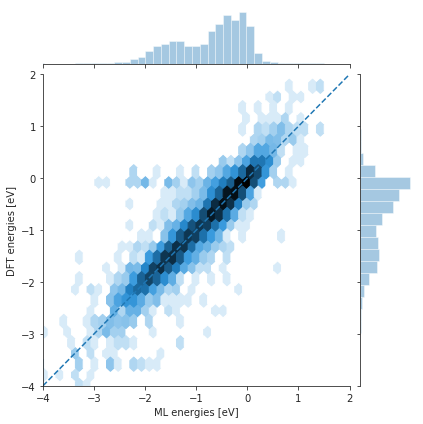

In [9]:
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

# Make the joint plot
plot_lims = (-4, 2)
grid = sns.jointplot('ML energies [eV]', 'DFT energies [eV]', data=df,
                     kind='hex', bins='log')
_ = grid.ax_joint.set_xlim(plot_lims)
_ = grid.ax_joint.set_ylim(plot_lims)

# Draw a parity line
_ = grid.ax_joint.plot(plot_lims, plot_lims, '--')

## Distribution of residuals

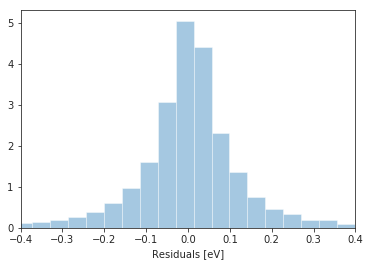

In [10]:
ax = sns.distplot(df['Residuals [eV]'], bins=200, kde=False, norm_hist=True)
_ = ax.set_xlim((-0.4, 0.4))

# Saving the predictions

In [11]:
from gaspy_regress.utils import save_pipeline_predictions

mongo_result = save_pipeline_predictions(pipeline, adsorbate, model_name)

0it [00:00, ?it/s]

Now pulling catalog documents...


2591434it [00:53, 48356.87it/s]
